In [1]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt

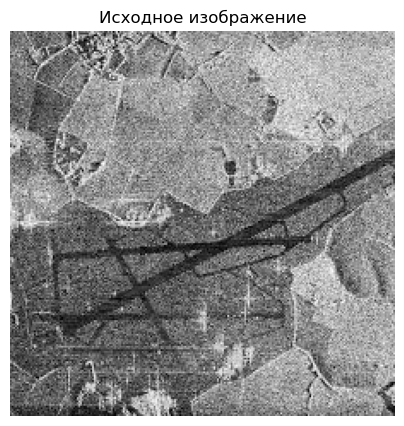

In [2]:
image_path = cv2.imread('sar_3.jpg')                 
image = cv2.cvtColor(image_path, cv2.COLOR_BGR2RGB)  
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

plt.figure(figsize=(5, 5))
plt.imshow(image_gray, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

In [3]:
# 1. Наиболее протяженный участок
# Canny
edges = cv2.Canny(image_gray, 50, 150, apertureSize=3)

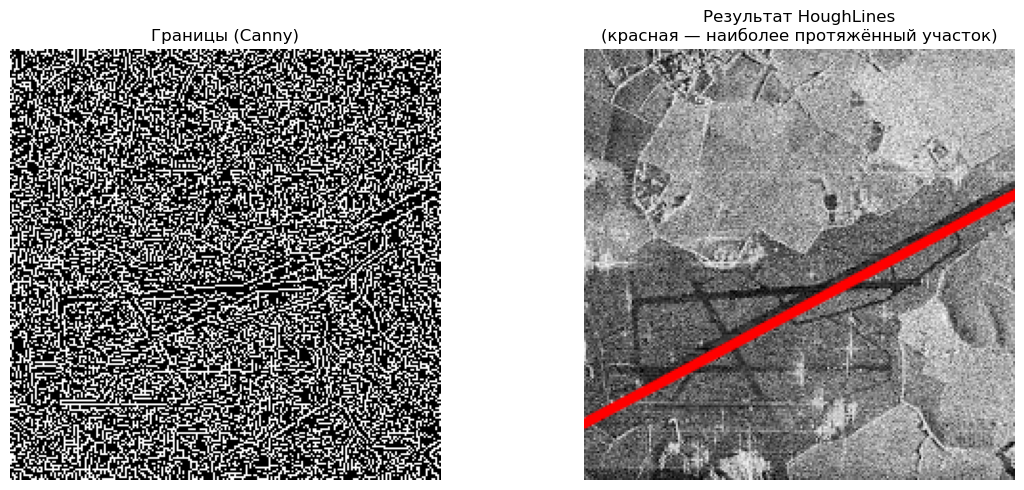

In [4]:
# Преобразование Хафа
lines = cv2.HoughLines(edges, 1, np.pi / 180, 140)

image_hough = image.copy()
longest_line_info = None
max_length = 0

if lines is not None:
    for i in range(len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]

        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho

        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))

        length = np.sqrt((pt2[0] - pt1[0]) ** 2 + (pt2[1] - pt1[1]) ** 2)

        if length > max_length:
            max_length = length
            longest_line_info = (rho, theta, pt1, pt2)

if longest_line_info is not None:
    rho, theta, pt1, pt2 = longest_line_info
    cv2.line(image_hough, pt1, pt2, (255, 0, 0), 4, cv2.LINE_AA)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title('Границы (Canny)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_hough)
plt.title('Результат HoughLines\n(красная — наиболее протяжённый участок)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
print("Максимальная длина линии (по построенным точкам):", max_length)

Максимальная длина линии (по построенным точкам): 1998.7668698475068


In [6]:
# 3. Исследование бинаризации
# Точечная бинаризация 
T = 50
bin_fixed = np.zeros_like(image_gray)
bin_fixed[image_gray >= T] = 255

In [7]:
# Бинаризация по Отсу
_, bin_otsu = cv2.threshold(image_gray, 0, 255,
                            cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [8]:
# Адаптивная бинаризация (Gaussian)
bin_adapt = cv2.adaptiveThreshold(image_gray, 255,
                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY,
                                  71, 21)

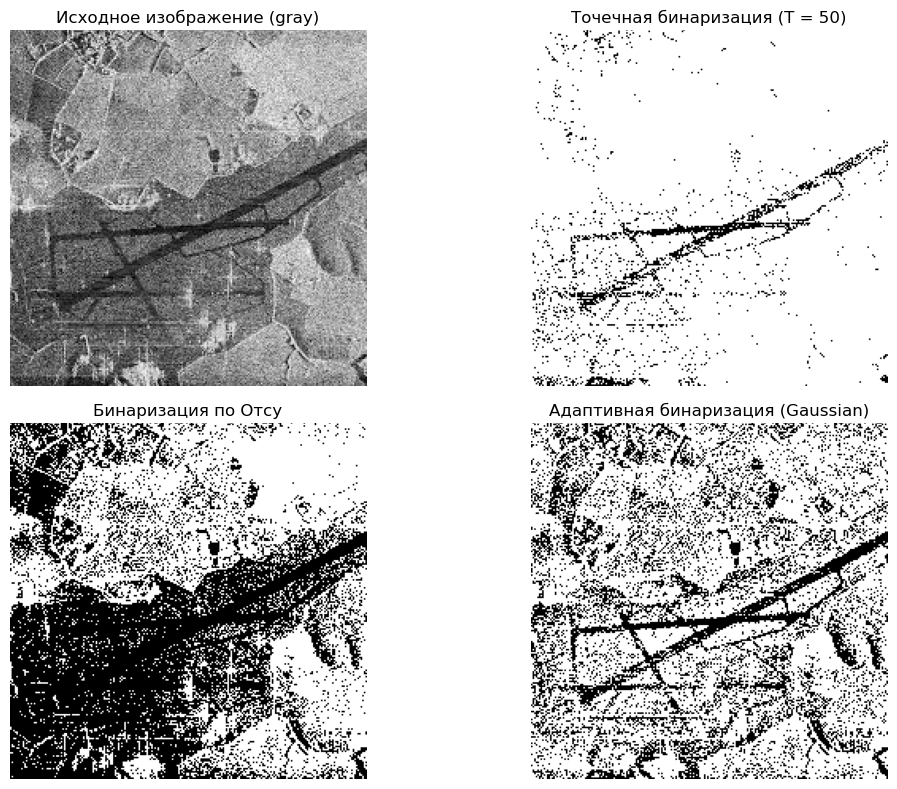

In [9]:

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Исходное изображение (gray)')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(bin_fixed, cmap='gray')
plt.title(f'Точечная бинаризация (T = {T})')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(bin_otsu, cmap='gray')
plt.title('Бинаризация по Отсу')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(bin_adapt, cmap='gray')
plt.title('Адаптивная бинаризация (Gaussian)')
plt.axis('off')

plt.tight_layout()
plt.show()


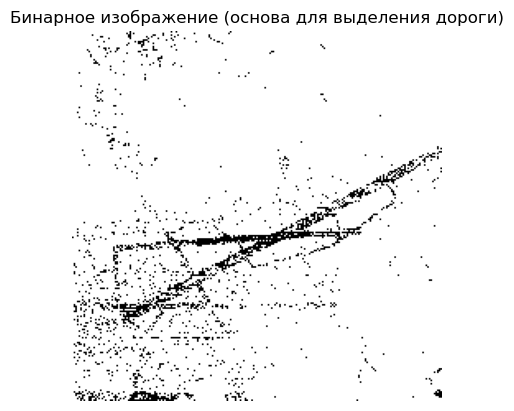

In [11]:
# Выделение участка дороги
bin_base = bin_fixed.copy()

plt.imshow(bin_base, cmap='gray')
plt.title('Бинарное изображение (основа для выделения дороги)')
plt.axis('off')
plt.show()

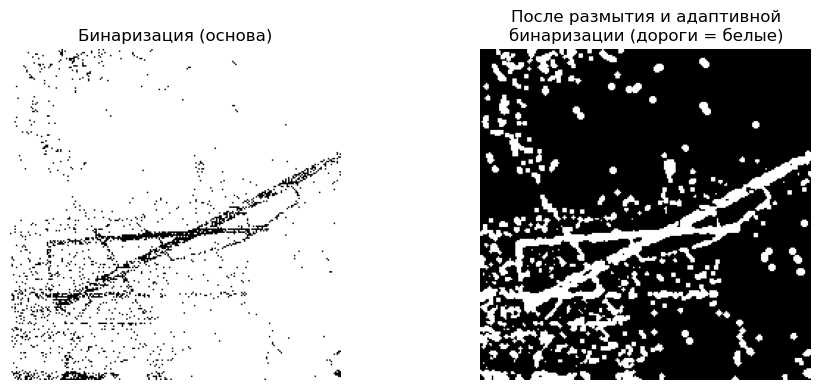

In [15]:
blur = cv2.GaussianBlur(bin_base, (5, 5), 0)

thresh = cv2.adaptiveThreshold(
    blur,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,  # инверсия: дороги = белые
    55,                     # размер окна (нечётное число)
    2                       # вычитаемая константа
)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(bin_base, cmap='gray')
plt.title('Бинаризация (основа)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(thresh, cmap='gray')
plt.title('После размытия и адаптивной\nбинаризации (дороги = белые)')
plt.axis('off')

plt.tight_layout()

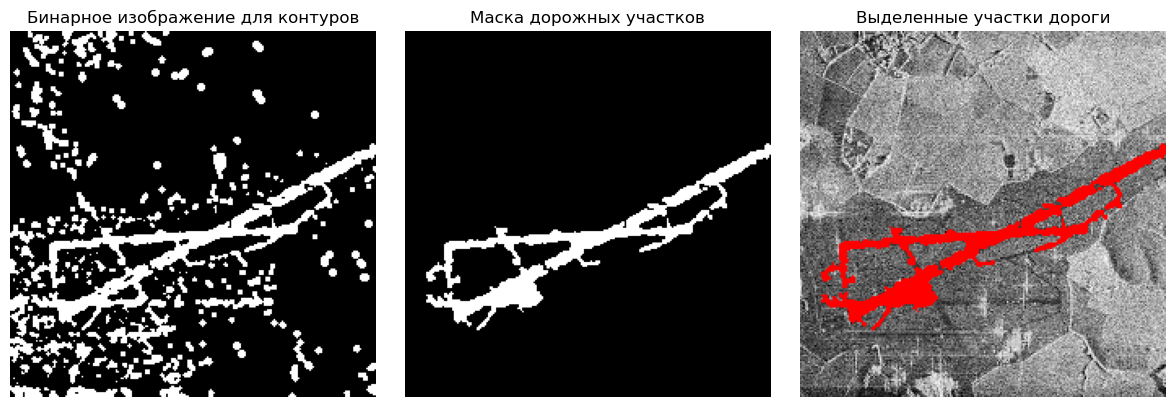

In [17]:
contours, _ = cv2.findContours(
    thresh,
    cv2.RETR_EXTERNAL,     
    cv2.CHAIN_APPROX_SIMPLE
)

road_mask = np.zeros_like(image_gray)  
image_with_roads = image.copy()      
min_area = 500 

if contours:
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area:
            cv2.fillPoly(road_mask, [contour], 255)
            cv2.fillPoly(image_with_roads, [contour], (255, 0, 0))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(thresh, cmap='gray')
plt.title('Бинарное изображение для контуров')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(road_mask, cmap='gray')
plt.title('Маска дорожных участков')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_with_roads)
plt.title('Выделенные участки дороги')
plt.axis('off')

plt.tight_layout()
plt.show()

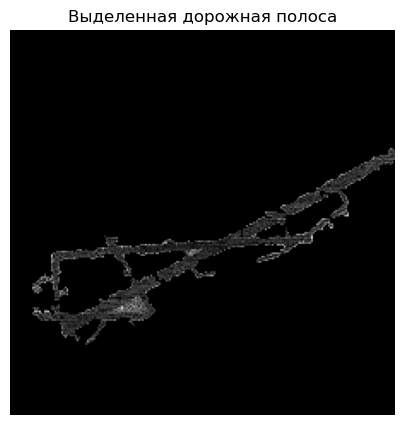

In [18]:
road_only = cv2.bitwise_and(image, image, mask=road_mask)


plt.figure(figsize=(5, 5))
plt.imshow(road_only)
plt.title('Выделенная дорожная полоса')
plt.axis('off')
plt.show()